In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import ray
from ray import tune
from ray import air
from ray.tune import CLIReporter
from ray.tune import Tuner
from ray.tune.schedulers import HyperBandScheduler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_log_error

/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-21 21:33:49,305	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-21 21:33:49,362	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
df = pd.read_csv('train.csv')
df.head()

id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0

In [3]:
df.isna().any()

id            False
Sex           False
Age           False
Height        False
Weight        False
Duration      False
Heart_Rate    False
Body_Temp     False
Calories      False
dtype: bool

In [4]:
df['Sex'].value_counts()

Sex
female    375721
male      374279
Name: count, dtype: int64

In [5]:
df['Sex'] = np.where(df['Sex'] == 'male', 1, 0)

In [6]:
df.drop('id', axis=1).corr()

Sex       Age    Height    Weight  Duration  Heart_Rate  \
Sex         1.000000  0.009689  0.755906  0.818250 -0.009594    0.009122   
Age         0.009689  1.000000  0.011975  0.073690  0.015656    0.017037   
Height      0.755906  0.011975  1.000000  0.957967 -0.029936   -0.013234   
Weight      0.818250  0.073690  0.957967  1.000000 -0.020845   -0.002384   
Duration   -0.009594  0.015656 -0.029936 -0.020845  1.000000    0.875327   
Heart_Rate  0.009122  0.017037 -0.013234 -0.002384  0.875327    1.000000   
Body_Temp  -0.015933  0.030275 -0.034641 -0.023717  0.903066    0.795972   
Calories    0.012011  0.145683 -0.004026  0.015863  0.959908    0.908748   

            Body_Temp  Calories  
Sex         -0.015933  0.012011  
Age          0.030275  0.145683  
Height      -0.034641 -0.004026  
Weight      -0.023717  0.015863  
Duration     0.903066  0.959908  
Heart_Rate   0.795972  0.908748  
Body_Temp    1.000000  0.828671  
Calories     0.828671  1.000000

<Axes: xlabel='Calories', ylabel='Count'>

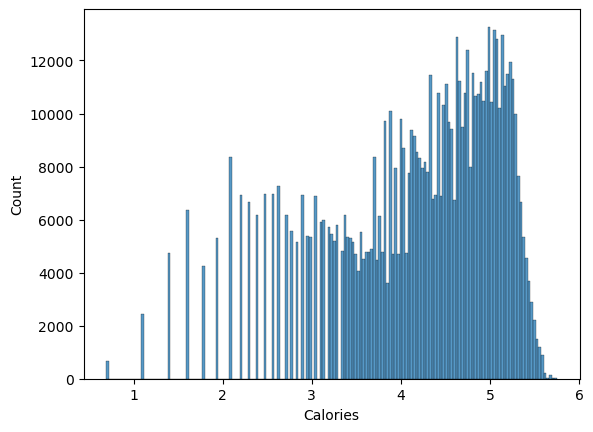

In [7]:
sns.histplot(np.log1p(df['Calories']))

<Axes: xlabel='Calories', ylabel='Count'>

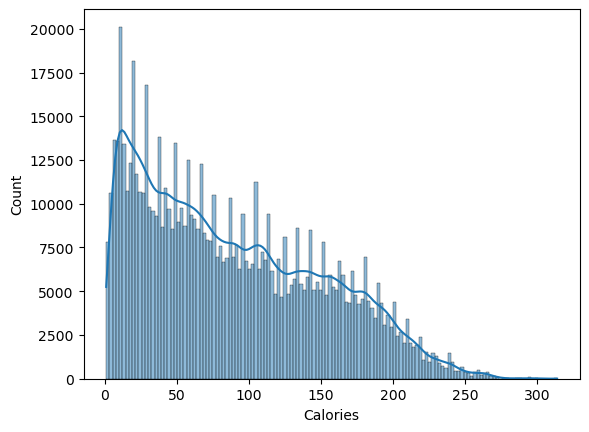

In [8]:
sns.histplot(df['Calories'], kde=True)

In [9]:
lower_bound = np.percentile(df['Calories'], 0)
upper_bound = np.percentile(df['Calories'], 99)
df['Calories'] = df['Calories'].clip(lower=lower_bound, upper=upper_bound)

<Axes: xlabel='Calories', ylabel='Count'>

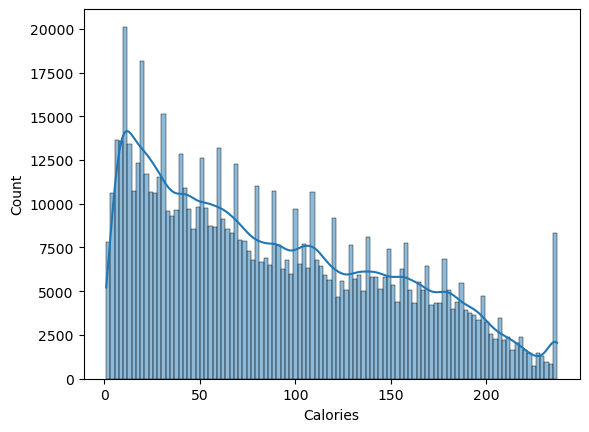

In [10]:
sns.histplot(df['Calories'], kde=True)

In [11]:
df['Body_Ratio'] = df['Weight'] / df['Height']
df['Body_Expenditure'] = df['Body_Ratio'] * df['Heart_Rate']
df['Difficulty'] = df['Heart_Rate'] / df['Age']
df['Temp_Dist'] = df['Body_Temp'] / df['Body_Ratio']
df['Impact'] = df['Duration'] * df['Heart_Rate']
df['Impact_Temp'] = df['Duration'] * df['Body_Temp']

In [12]:
df.drop(['id', 'Calories'], axis=1)

Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Body_Ratio  \
0         1   36   189.0    82.0      26.0       101.0       41.0    0.433862   
1         0   64   163.0    60.0       8.0        85.0       39.7    0.368098   
2         0   51   161.0    64.0       7.0        84.0       39.8    0.397516   
3         1   20   192.0    90.0      25.0       105.0       40.7    0.468750   
4         0   38   166.0    61.0      25.0       102.0       40.6    0.367470   
...     ...  ...     ...     ...       ...         ...        ...         ...   
749995    1   28   193.0    97.0      30.0       114.0       40.9    0.502591   
749996    0   64   165.0    63.0      18.0        92.0       40.5    0.381818   
749997    1   60   162.0    67.0      29.0       113.0       40.9    0.413580   
749998    1   45   182.0    91.0      17.0       102.0       40.3    0.500000   
749999    0   39   171.0    65.0      19.0        97.0       40.6    0.380117   

        Body_Expenditure  Difficulty   Temp_Dist  Impact  Impact_Temp  
0              43.820106    2.805556   94.500000  2626.0       1066.0  
1              31.288344    1.328125  107.851667   680.0        317.6  
2              33.391304    1.647059  100.121875   588.0        278.6  
3              49.218750    5.250000   86.826667  2625.0       1017.5  
4              37.481928    2.684211  110.485246  2550.0       1015.0  
...                  ...         ...         ...     ...          ...  
749995         57.295337    4.071429   81.378351  3420.0       1227.0  
749996         35.127273    1.437500  106.071429  1656.0        729.0  
749997         46.734568    1.883333   98.892537  3277.0       1186.1  
749998         51.000000    2.266667   80.600000  1734.0        685.1  
749999         36.871345    2.487179  106.809231  1843.0        771.4  

[750000 rows x 13 columns]

In [13]:
men = df[df['Sex'] == 1].drop('Sex', axis=1)
women = df[df['Sex'] == 0].drop('Sex', axis=1)

In [14]:
X_train_men = men.drop(['id', 'Calories'], axis=1)
y_train_men = np.log1p(men['Calories'])

X_train_women = women.drop(['id', 'Calories'], axis=1)
y_train_women = np.log1p(women['Calories'])

In [15]:
data = {
    "X_train_men": X_train_men,
    "y_train_men": y_train_men,
    "X_train_women": X_train_women,
    "y_train_women": y_train_women
}

datasets = ray.put(data)

2025-05-21 21:33:54,148	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


In [16]:
def makeXGB(config):
    data = ray.get(datasets)

    if config['genre'] == 'men':
        X = data['X_train_men']
        y = data['y_train_men']
    else:
        X = data['X_train_women']
        y = data['y_train_women']

    def safe_msle(y_true, y_pred):
        y_pred_clipped = np.maximum(0, y_pred)
        return mean_squared_log_error(y_true, y_pred_clipped)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBRegressor(**config)
        model.fit(X_tr, y_tr)

        preds_val = model.predict(X_val)
        score = safe_msle(np.expm1(y_val), np.expm1(preds_val))
        fold_scores.append(score)

    mean_score = np.mean(fold_scores)

    ray.train.report(metrics={
        'neg_mean_squared_log_error': -mean_score
    })

In [17]:
config = {
    'max_depth': tune.randint(1, 100),
    'max_leaves': tune.randint(2, 100),
    'learning_rate': tune.uniform(0.01, 0.2),
    'n_estimators': tune.randint(50, 300),
    'eta': tune.loguniform(1e-5, 0.1),
    'subsample': tune.uniform(0.5, 1.0),
    'colsample_bytree': tune.uniform(0.5, 1.0),
    'gamma': tune.uniform(0, 10),
    'min_child_weight': tune.randint(5, 30),
    'lambda': tune.loguniform(1e-8, 1e-2),
    'alpha': tune.loguniform(1e-4, 10),
}

In [18]:
models = {}
for genre in ['men', 'women']:
    config['genre'] = genre

    reporter = CLIReporter(
        metric='neg_mean_squared_log_error',
        mode='max'
    )

    hyperband = HyperBandScheduler(
        metric='neg_mean_squared_log_error',
        mode='max'
    )

    tuner = Tuner(
        tune.with_resources(makeXGB, resources={"gpu": 1}),
        param_space=config,
        tune_config=tune.TuneConfig(num_samples=100, scheduler=hyperband),
        run_config=air.RunConfig(progress_reporter=reporter)
    )

    analysis = tuner.fit()

    best = analysis.get_best_result(metric='neg_mean_squared_log_error', mode='max')
    best = best.config

    best['eval_metric'] = 'rmse'
    best['random_state'] = 47
    best['n_estimators'] = 10000
    best['early_stopping_rounds'] = 5
    del best['genre']

    if genre == 'men':
        X_train, y_train = X_train_men, y_train_men
    else:
        X_train, y_train = X_train_women, y_train_women

    endmodel = XGBRegressor(**best)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=47)
    endmodel.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    models[genre] = endmodel

2025-05-21 21:33:54,830	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-05-21 21:33:57 (running for 00:00:01.12)
Using HyperBand: num_stopped=0 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=0.0%): {PENDING: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 34} 
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.0%): {PENDING: 81} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=0.0%): {PENDING: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-21_21-33-53_166678_121405/artifacts/2025-05-21_21-33-54/makeXGB_

(makeXGB pid=123298) [21:33:58] WARNING: /workspace/src/learner.cc:740: 
(makeXGB pid=123298) Parameters: { "genre" } are not used.
(makeXGB pid=123298) 
(makeXGB pid=123298) [21:34:00] WARNING: /workspace/src/learner.cc:740: 
(makeXGB pid=123298) Parameters: { "genre" } are not used.
(makeXGB pid=123298) 
(makeXGB pid=123298) [21:34:01] WARNING: /workspace/src/learner.cc:740: 
(makeXGB pid=123298) Parameters: { "genre" } are not used.
(makeXGB pid=123298) 
(makeXGB pid=123298) [21:34:03] WARNING: /workspace/src/learner.cc:740: 
(makeXGB pid=123298) Parameters: { "genre" } are not used.
(makeXGB pid=123298) 
(makeXGB pid=123298) [21:34:05] WARNING: /workspace/src/learner.cc:740: 
(makeXGB pid=123298) Parameters: { "genre" } are not used.
(makeXGB pid=123298) 
(makeXGB pid=123627) 
(makeXGB pid=123627) 
(makeXGB pid=123627) 
(makeXGB pid=123627) [21:34:11] WARNING: /workspace/src/learner.cc:740:  [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to dis

2025-05-21 22:03:28,345	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:03:30 (running for 00:29:34.08)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 24, PENDING: 1, RUNNING: 1, TERMINATED: 55} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:03:36,440	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:03:40 (running for 00:29:44.19)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 23, PENDING: 1, RUNNING: 1, TERMINATED: 56} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:03:44,782	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:03:45 (running for 00:29:49.20)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 23, PENDING: 1, TERMINATED: 57} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mean

2025-05-21 22:03:52,542	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:03:55 (running for 00:29:59.29)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 21, PENDING: 1, RUNNING: 1, TERMINATED: 58} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:04:02,740	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:04:05 (running for 00:30:09.35)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 20, PENDING: 1, RUNNING: 1, TERMINATED: 59} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:04:12,348	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:04:15 (running for 00:30:19.46)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 19, PENDING: 1, RUNNING: 1, TERMINATED: 60} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:04:20,362	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:04:20 (running for 00:30:24.48)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 19, PENDING: 1, TERMINATED: 61} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mean

2025-05-21 22:04:26,625	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:04:30 (running for 00:30:34.53)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 17, PENDING: 1, RUNNING: 1, TERMINATED: 62} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:04:36,842	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:04:40 (running for 00:30:44.66)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 16, PENDING: 1, RUNNING: 1, TERMINATED: 63} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:04:49,913	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:04:50 (running for 00:30:54.73)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 16, PENDING: 1, TERMINATED: 64} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_me

2025-05-21 22:04:57,607	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:00 (running for 00:31:04.83)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 14, PENDING: 1, RUNNING: 1, TERMINATED: 65} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:05:07,271	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:10 (running for 00:31:14.93)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 13, PENDING: 1, RUNNING: 1, TERMINATED: 66} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:05:15,331	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:15 (running for 00:31:19.95)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 13, PENDING: 1, TERMINATED: 67} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_me

2025-05-21 22:05:21,992	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:26 (running for 00:31:30.03)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 11, PENDING: 1, RUNNING: 1, TERMINATED: 68} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077

2025-05-21 22:05:34,678	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:36 (running for 00:31:40.10)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 11, PENDING: 1, TERMINATED: 69} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_me

2025-05-21 22:05:44,894	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:46 (running for 00:31:50.21)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 10, PENDING: 1, TERMINATED: 70} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_me

2025-05-21 22:05:53,057	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:05:56 (running for 00:32:00.33)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 8, PENDING: 1, RUNNING: 1, TERMINATED: 71} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 

2025-05-21 22:06:07,480	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:06:11 (running for 00:32:15.43)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 7, PENDING: 1, RUNNING: 1, TERMINATED: 72} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 

2025-05-21 22:06:15,529	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:06:16 (running for 00:32:20.45)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 7, PENDING: 1, TERMINATED: 73} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mean_

2025-05-21 22:06:27,286	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:06:31 (running for 00:32:35.56)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 5, PENDING: 1, RUNNING: 1, TERMINATED: 74} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 

2025-05-21 22:06:35,745	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:06:36 (running for 00:32:40.56)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 5, PENDING: 1, TERMINATED: 75} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mea

2025-05-21 22:06:48,516	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:06:51 (running for 00:32:55.64)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 3, PENDING: 1, RUNNING: 1, TERMINATED: 76} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 

2025-05-21 22:06:55,543	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:06:56 (running for 00:33:00.66)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 3, PENDING: 1, TERMINATED: 77} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mea

2025-05-21 22:07:04,454	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:07:06 (running for 00:33:10.84)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 1, PENDING: 1, RUNNING: 1, TERMINATED: 78} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 

2025-05-21 22:07:13,877	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:07:16 (running for 00:33:20.93)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PENDING: 1, RUNNING: 1, TERMINATED: 79} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_me

2025-05-21 22:07:23,675	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:07:27 (running for 00:33:31.02)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {RUNNING: 1, TERMINATED: 80} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mean_squared_l

2025-05-21 22:07:34,888	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1
2025-05-21 22:07:34,909	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2025-05-21_21-33-54' in 0.0167s.
2025-05-21 22:07:34,945	INFO tune.py:1041 -- Total run time: 2020.12 seconds (2018.90 seconds for the tuning loop).


== Status ==
Current time: 2025-05-21 22:07:34 (running for 00:33:38.92)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {TERMINATED: 81} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 7116d_00077 with neg_mean_squared_log_error=-0.

2025-05-21 22:07:38,227	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


== Status ==
Current time: 2025-05-21 22:07:39 (running for 00:00:00.91)
Using HyperBand: num_stopped=0 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=0.0%): {PENDING: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 34} 
  Bracket(Max Size (n)=81, Milestone (r)=1, completed=0.0%): {PENDING: 81} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=0.0%): {PENDING: 5} 
  Bracket(Max Size (n)=8, Milestone (r)=27, completed=0.0%): {PENDING: 8} 
  Bracket(Max Size (n)=15, Milestone (r)=9, completed=0.0%): {PENDING: 15} 
  Bracket(Max Size (n)=34, Milestone (r)=3, completed=0.0%): {PENDING: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: /tmp/ray/session_2025-05-21_21-33-53_166678_121405/artifacts/2025-05-21_22-07-38/makeXGB_

2025-05-21 22:36:43,557	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:36:46 (running for 00:29:08.02)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 23, PENDING: 1, RUNNING: 1, TERMINATED: 56} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:36:51,754	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:36:56 (running for 00:29:18.13)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 22, PENDING: 1, RUNNING: 1, TERMINATED: 57} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:37:05,713	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:37:06 (running for 00:29:28.19)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 22, PENDING: 1, TERMINATED: 58} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_me

2025-05-21 22:37:13,289	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:37:16 (running for 00:29:38.33)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 20, PENDING: 1, RUNNING: 1, TERMINATED: 59} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:37:22,877	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:37:26 (running for 00:29:48.43)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 19, PENDING: 1, RUNNING: 1, TERMINATED: 60} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:37:31,131	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:37:31 (running for 00:29:53.51)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 19, PENDING: 1, TERMINATED: 61} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean

2025-05-21 22:37:41,355	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:37:41 (running for 00:30:03.63)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 18, PENDING: 1, TERMINATED: 62} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean

2025-05-21 22:37:50,435	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:37:51 (running for 00:30:13.71)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 16, PENDING: 1, RUNNING: 1, TERMINATED: 63} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:37:58,531	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:02 (running for 00:30:23.84)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 15, PENDING: 1, RUNNING: 1, TERMINATED: 64} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:38:06,030	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:07 (running for 00:30:28.91)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 15, PENDING: 1, TERMINATED: 65} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_me

2025-05-21 22:38:14,804	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:17 (running for 00:30:39.05)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 13, PENDING: 1, RUNNING: 1, TERMINATED: 66} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:38:22,252	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:22 (running for 00:30:44.12)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 13, PENDING: 1, TERMINATED: 67} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean

2025-05-21 22:38:32,299	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:32 (running for 00:30:54.17)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 12, PENDING: 1, TERMINATED: 68} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean

2025-05-21 22:38:38,108	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:42 (running for 00:31:04.33)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 10, PENDING: 1, RUNNING: 1, TERMINATED: 69} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125

2025-05-21 22:38:46,147	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:38:47 (running for 00:31:09.42)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 10, PENDING: 1, TERMINATED: 70} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_me

2025-05-21 22:39:02,105	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:02 (running for 00:31:24.58)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 9, PENDING: 1, TERMINATED: 71} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean_

2025-05-21 22:39:08,468	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:12 (running for 00:31:34.74)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 7, PENDING: 1, RUNNING: 1, TERMINATED: 72} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 

2025-05-21 22:39:14,799	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:18 (running for 00:31:39.84)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 6, PENDING: 1, RUNNING: 1, TERMINATED: 73} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 

2025-05-21 22:39:24,460	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:28 (running for 00:31:49.94)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 5, PENDING: 1, RUNNING: 1, TERMINATED: 74} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 

2025-05-21 22:39:32,822	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:33 (running for 00:31:55.00)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 5, PENDING: 1, TERMINATED: 75} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mea

2025-05-21 22:39:40,465	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:43 (running for 00:32:05.13)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 3, PENDING: 1, RUNNING: 1, TERMINATED: 76} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 

2025-05-21 22:39:50,237	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:53 (running for 00:32:15.18)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 2, PENDING: 1, RUNNING: 1, TERMINATED: 77} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 

2025-05-21 22:39:56,876	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:39:58 (running for 00:32:20.24)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 1, PENDING: 1, RUNNING: 1, TERMINATED: 78} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 

2025-05-21 22:40:03,196	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:40:03 (running for 00:32:25.27)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {PAUSED: 1, PENDING: 1, TERMINATED: 79} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean_

2025-05-21 22:40:11,489	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1


== Status ==
Current time: 2025-05-21 22:40:13 (running for 00:32:35.40)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {RUNNING: 1, TERMINATED: 80} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean_squared_l

2025-05-21 22:40:20,395	INFO hyperband.py:543 -- Restoring from a previous point in time. Previous=1; Now=1
2025-05-21 22:40:20,425	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/nicomore/ray_results/makeXGB_2025-05-21_22-07-38' in 0.0260s.
2025-05-21 22:40:20,436	INFO tune.py:1041 -- Total run time: 1962.21 seconds (1962.17 seconds for the tuning loop).


== Status ==
Current time: 2025-05-21 22:40:20 (running for 00:32:42.19)
Using HyperBand: num_stopped=54 total_brackets=9
Round #0:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=7.2%): {TERMINATED: 34} 
  Bracket(Max Size (n)=27, Milestone (r)=3, completed=20.0%): {TERMINATED: 81} 
Round #1:
  Bracket(Max Size (n)=5, Milestone (r)=81, completed=100.0%): {TERMINATED: 5} 
  Bracket(Max Size (n)=3, Milestone (r)=81, completed=100.0%): {TERMINATED: 8} 
  Bracket(Max Size (n)=5, Milestone (r)=27, completed=3.6%): {TERMINATED: 15} 
  Bracket(Max Size (n)=12, Milestone (r)=9, completed=6.1%): {TERMINATED: 29} 
Logical resource usage: 0/24 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Current best trial: 2720b_00125 with neg_mean_squared_log_error=-0.

In [19]:
models

[{'men': XGBRegressor(alpha=0.05389063880936984, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7136035585473127, device=None,
               early_stopping_rounds=5, enable_categorical=False,
               eta=4.372875951406619e-05, eval_metric='rmse', feature_types=None,
               gamma=0.31328903092370686, grow_policy=None, importance_type=None,
               interaction_constraints=None, lambda=0.003071340386245553,
               learning_rate=0.11331467349322766, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=95, max_leaves=83,
               min_child_weight=7, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=10000, ...)},
 {'women': XGBRegressor(alpha=0.20135215322512634, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None, colsam

In [26]:
explainer = shap.Explainer(models['men'])
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

TypeError: list indices must be integers or slices, not str

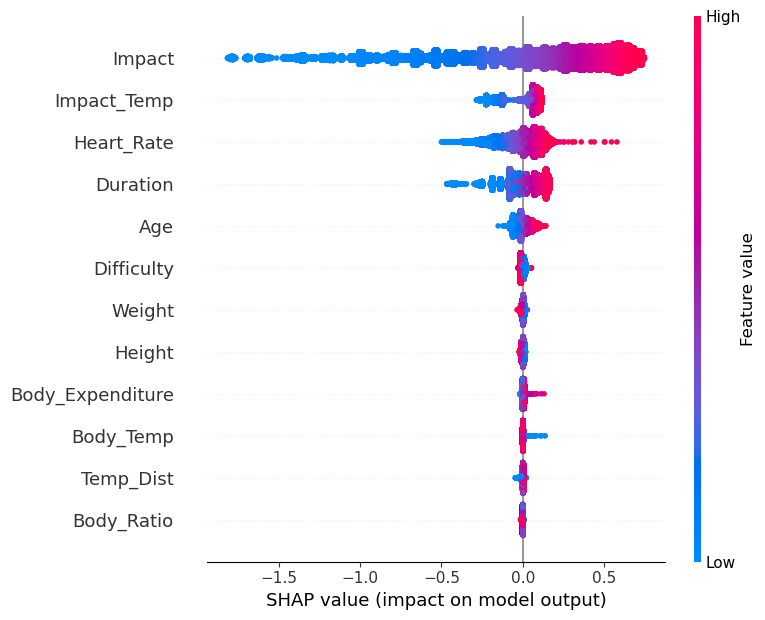

In [21]:
explainer = shap.Explainer(models['women'])
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [22]:
test = pd.read_csv('test.csv')
test['Sex'] = np.where(test['Sex'] == 'male', 1, 0)
test['Body_Ratio'] = test['Weight'] / test['Height']
test['Body_Expenditure'] = test['Body_Ratio'] * test['Heart_Rate']
test['Difficulty'] = test['Heart_Rate'] / test['Age']
test['Temp_Dist'] = test['Body_Temp'] / test['Body_Ratio']
test['Impact'] = test['Duration'] * test['Heart_Rate']
test['Impact_Temp'] = test['Duration'] * test['Body_Temp']

In [ ]:
tmen = test[test['Sex'] == 1].drop('Sex', axis=1)
twomen = test[test['Sex'] == 0].drop('Sex', axis=1)

In [ ]:
aaaaaaaaaa

In [23]:
pred = endmodel.predict(test.drop('id', axis=1))

ValueError: feature_names mismatch: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Body_Ratio', 'Body_Expenditure', 'Difficulty', 'Temp_Dist', 'Impact', 'Impact_Temp'] ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Body_Ratio', 'Body_Expenditure', 'Difficulty', 'Temp_Dist', 'Impact', 'Impact_Temp']
training data did not have the following fields: Sex

In [ ]:
test['Calories'] = np.maximum(0, np.expm1(pred))

In [ ]:
test

id    Calories
0       750000   28.323805
1       750001  109.289299
2       750002   89.113976
3       750003  123.541718
4       750004   75.905762
...        ...         ...
249995  999995   25.215509
249996  999996    9.065795
249997  999997   70.789001
249998  999998  170.722412
249999  999999   72.051895

[250000 rows x 2 columns]

In [ ]:
test.to_csv('submission.csv', index=False)